In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
from time import time
import matplotlib.pyplot as plt

from numba import njit
import tensorflow as tf

import sys
sys.path.append('../../../')
from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.diagnostics import *
from bayesflow.models import GenerativeModel

In [2]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------

    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    ----------

    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """

    # Prior ranges for the simulator
    # drift ~ U(-3.0, 3.0)
    # boundary ~ U(0.5, 4.0)
    # beta ~ U(0.1, 0.9)  # relative start point
    # mu_tau_e ~ U(0.05, 0.6)
    # tau_m ~ U(0.06, 0.8)
    # sigma ~ U(0, 0.3)
    # varsigma ~ U(0, 0.3)
    n_parameters = 7
    p_samples = np.random.uniform(low=(-3.0, 0.5, 0.1, 0.05, 0.06, 0.0, 0.0),
                                  high=(3.0, 2.0, 0.9, 0.6,  0.8,  0.3, 0.3), size=(batch_size, n_parameters))
    return p_samples.astype(np.float32)

@njit
def diffusion_trial(drift, boundary, beta, mu_tau_e, tau_m, sigma, varsigma, dc=1.0, dt=.005):
    """Simulates a trial from the diffusion model."""

    n_steps = 0.
    evidence = boundary * beta
    
    # Simulate a single DM path
    while (evidence > 0 and evidence < boundary):

        # DDM equation
        evidence += drift*dt + np.sqrt(dt) * dc * np.random.normal()

        # Increment step
        n_steps += 1.0

    rt = n_steps * dt

    
    # visual encoding time for each trial
    tau_e_trial = np.random.normal(mu_tau_e, varsigma)

    # N200 latency
    z = np.random.normal(tau_e_trial, sigma)
    
    if evidence >= boundary:
        choicert =  tau_e_trial + rt + tau_m
        
    else:
        choicert = -tau_e_trial - rt - tau_m
    return choicert, z

@njit
def diffusion_condition(params, n_trials):
    """Simulates a diffusion process over an entire condition."""

    drift, boundary, beta, mu_tau_e, tau_m, sigma, varsigma = params
    choicert = np.empty(n_trials)
    z = np.empty(n_trials)
    for i in range(n_trials):
        choicert[i], z[i] = diffusion_trial(drift, boundary, beta, mu_tau_e, tau_m, sigma, varsigma)
    return choicert, z

def batch_simulator(prior_samples, n_obs, dt=0.005, s=1.0):
    """
    Simulate multiple diffusion_model_datasets.
    """

    n_sim = prior_samples.shape[0]
    sim_choicert = np.empty((n_sim, n_obs), dtype=np.float32)
    sim_z = np.empty((n_sim, n_obs), dtype=np.float32)

    # Simulate diffusion data
    for i in range(n_sim):
        sim_choicert[i], sim_z[i] = diffusion_condition(prior_samples[i], n_obs)

    # For some reason BayesFlow wants there to be at least two data dimensions
    sim_data = np.stack([sim_choicert, sim_z], axis=-1)
    return sim_data

# Connect the networks through a SingleModelAmortizer instance.
summary_net = InvariantNetwork()
inference_net = InvertibleNetwork({'n_params': 7})
amortizer = SingleModelAmortizer(inference_net, summary_net)

# Connect the prior and simulator through a GenerativeModel class which will take care of forward inference.
generative_model = GenerativeModel(prior, batch_simulator)

trainer = ParameterEstimationTrainer(
    network=amortizer,
    generative_model=generative_model,
    checkpoint_path="../../checkpoint/N200_single_trial"
)

Networks loaded from ../../checkpoint/N200_single_trial/ckpt-1000


In [4]:
data = pd.read_csv('N200_rt_window_150_275.csv')

In [36]:
parts = 14
data_srn0 = data[(data[' True Subject Index'] == parts)&(data[' Experiment']==2)&(data[' SNR condition']==0)]
data_srn1 = data[(data[' True Subject Index'] == parts)&(data[' Experiment']==2)&(data[' SNR condition']==1)]
data_srn2 = data[(data[' True Subject Index'] == parts)&(data[' Experiment']==2)&(data[' SNR condition']==2)]

In [37]:
# Convert 0,1 accuracy to -1,1 code
data_srn0[' Accuracy'] = data_srn0[' Accuracy'].replace(0,-1)
# Two different responses, [rt, N200 latency]
data_rt_z_1 = np.array([(data_srn0[' RT']/1000)*data_srn0[' Accuracy'], data_srn0['# Single-trial N200 latencies']/1000]).T

# Convert 0,1 accuracy to -1,1 code
data_srn1[' Accuracy'] = data_srn1[' Accuracy'].replace(0,-1)
# Two different responses, [rt, N200 latency]
data_rt_z_2 = np.array([(data_srn1[' RT']/1000)*data_srn1[' Accuracy'], data_srn1['# Single-trial N200 latencies']/1000]).T

# Convert 0,1 accuracy to -1,1 code
data_srn2[' Accuracy'] = data_srn2[' Accuracy'].replace(0,-1)
# Two different responses, [rt, N200 latency]
data_rt_z_3 = np.array([(data_srn2[' RT']/1000)*data_srn2[' Accuracy'], data_srn2['# Single-trial N200 latencies']/1000]).T

/home/a.ghaderi/.conda/envs/envjm/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/a.ghaderi/.conda/envs/envjm/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/a.ghaderi/.conda/envs/envjm/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [38]:
data_srn2.shape

(667, 9)

In [39]:
# Validate (quick and dirty) by a specific real data
n_param_sets = 1000
n_samples = 1000

param_samples_real_data1 = amortizer.sample(data_rt_z_1.reshape(1,data_srn0.shape[0],2), n_samples=n_samples)
param_samples_real_data2 = amortizer.sample(data_rt_z_2.reshape(1,data_srn1.shape[0],2), n_samples=n_samples)
param_samples_real_data3 = amortizer.sample(data_rt_z_3.reshape(1,data_srn2.shape[0],2), n_samples=n_samples)

In [40]:
print(['drift', 'boundary', 'beta', 'mu_tau_e', 'mu_tau_m', 'sigma', 'varsigma']),
param_samples_real_data1.mean(axis=0)

['drift', 'boundary', 'beta', 'mu_tau_e', 'mu_tau_m', 'sigma', 'varsigma']


array([1.2085346 , 1.1931971 , 0.5855584 , 0.22272584, 0.3674015 ,
       0.02856152, 0.01897918], dtype=float32)

In [41]:
print(['drift', 'boundary', 'beta', 'mu_tau_e', 'mu_tau_m', 'sigma', 'varsigma']),
param_samples_real_data2.mean(axis=0)

['drift', 'boundary', 'beta', 'mu_tau_e', 'mu_tau_m', 'sigma', 'varsigma']


array([1.7345755 , 1.2224662 , 0.5674589 , 0.20863119, 0.3477566 ,
       0.02548001, 0.01835055], dtype=float32)

In [42]:
print(['drift', 'boundary', 'beta', 'mu_tau_e', 'mu_tau_m', 'sigma', 'varsigma']),
param_samples_real_data3.mean(axis=0)

['drift', 'boundary', 'beta', 'mu_tau_e', 'mu_tau_m', 'sigma', 'varsigma']


array([1.6799489 , 1.2364497 , 0.58194214, 0.19892304, 0.36351618,
       0.02579818, 0.01972954], dtype=float32)

In [43]:
x_predict_1 = batch_simulator(param_samples_real_data1, 2000).astype(np.float32)
x_predict_2 = batch_simulator(param_samples_real_data2, 2000).astype(np.float32)
x_predict_3 = batch_simulator(param_samples_real_data3, 2000).astype(np.float32)

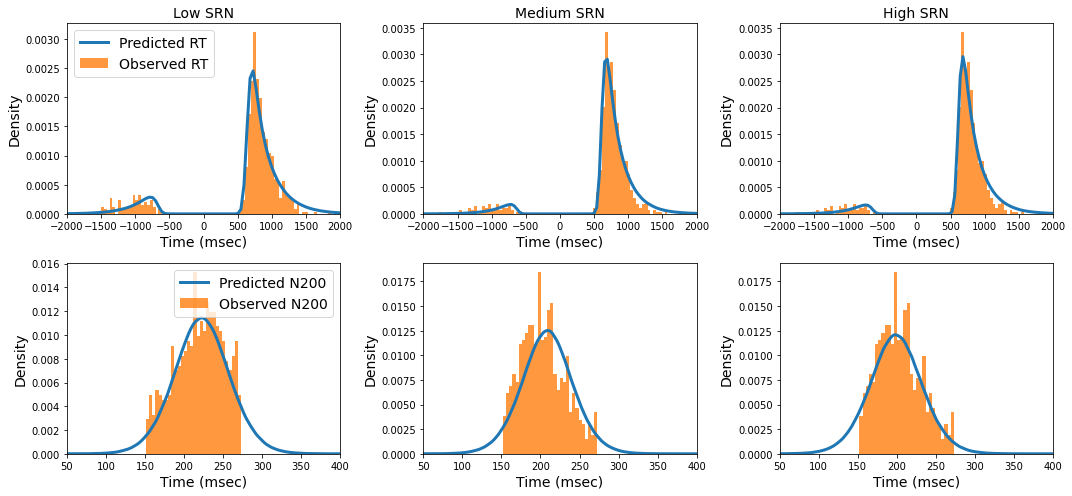

In [44]:
fig, axes = plt.subplots(2, 3, figsize=(15,7), tight_layout=True)

sns.kdeplot(1000*x_predict_1[:,:,0].flatten(), ax = axes[0,0], linewidth = 3)
axes[0,0].hist(1000*data_rt_z_1[:,0], density=True, bins = 80, alpha=0.8)
axes[0,0].legend(['Predicted RT', 'Observed RT'], fontsize=14)
axes[0,0].set_title('Low SRN', fontsize=14)
axes[0,0].set_xlabel('Time (msec)', fontsize=14)
axes[0,0].set_ylabel('Density', fontsize=14)
axes[0,0].set_xlim([-2000,2000])

sns.kdeplot(1000*x_predict_1[:,:,1].flatten(), ax = axes[1,0], linewidth = 3)
axes[1,0].hist(1000*data_rt_z_1[:,1], density=True, bins = 30, alpha=0.8)
axes[1,0].legend(['Predicted N200', 'Observed N200'], fontsize=14)
axes[1,0].set_xlabel('Time (msec)', fontsize=14)
axes[1,0].set_ylabel('Density', fontsize=14)
axes[1,0].set_xlim([50,400])

sns.kdeplot(1000*x_predict_2[:,:,0].flatten(), ax = axes[0,1], linewidth = 3)
axes[0,1].hist(1000*data_rt_z_2[:,0], density=True, bins = 80, alpha=0.8)
axes[0,1].set_xlabel('Time (msec)', fontsize=14)
axes[0,1].set_title('Medium SRN', fontsize=14)
axes[0,1].set_ylabel('Density', fontsize=14)
axes[0,1].set_xlim([-2000,2000])

sns.kdeplot(1000*x_predict_2[:,:,1].flatten(), ax = axes[1,1], linewidth = 3)
axes[1,1].hist(1000*data_rt_z_2[:,1], density=True, bins = 30, alpha=0.8)
axes[1,1].set_xlabel('Time (msec)', fontsize=14)
axes[1,1].set_ylabel('Density', fontsize=14)
axes[1,1].set_xlim([50,400])

sns.kdeplot(1000*x_predict_3[:,:,0].flatten(), ax = axes[0,2], linewidth = 3)
axes[0,2].hist(1000*data_rt_z_2[:,0], density=True, bins = 80, alpha=0.8)
axes[0,2].set_title('High SRN', fontsize=14)
axes[0,2].set_xlabel('Time (msec)', fontsize=14)
axes[0,2].set_ylabel('Density', fontsize=14)
axes[0,2].set_xlim([-2000,2000])

sns.kdeplot(1000*x_predict_3[:,:,1].flatten(), ax = axes[1,2], linewidth = 3)
axes[1,2].hist(1000*data_rt_z_2[:,1], density=True, bins = 30, alpha=0.8)
axes[1,2].set_xlabel('Time (msec)', fontsize=14)
axes[1,2].set_ylabel('Density', fontsize=14)
axes[1,2].set_xlim([50,400])

fig.savefig('Figures/nunez_2019_part_'+parts+'.png')